# 5. Handwritten digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

data=np.float64(np.load('MNIST.npy'))/255
labels=np.float32(np.load('MNIST_labels.npy'))


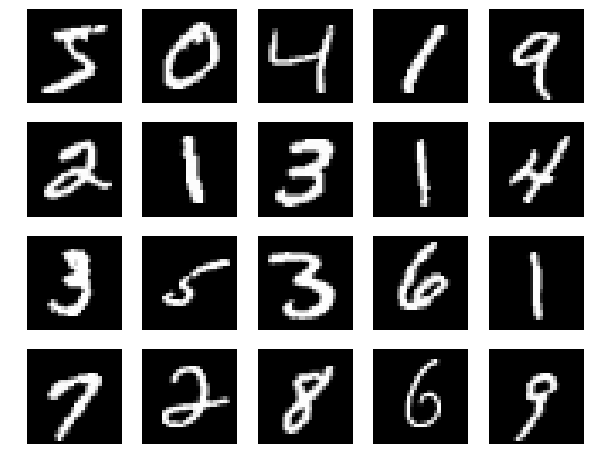

In [2]:
nrows = 4
ncols = 5
subset = data[:32]
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
   plt.subplot(nrows, ncols, i+1)
   plt.imshow(subset[i].reshape((28,28)), cmap='gray')
   plt.axis('off')
plt.axis('off')
plt.show()


## Part 1: PCA

#### (a) Extract principal components. 
Perform PCA to extract the principal components of the training data. You may not use a library to do PCA for you, but you may use libraries (for example from numpy) to compute the singular value or eigenvalue decomposition of a matrix. Display the first 10 principal components as images.

In [3]:
data1T = data.T

Mu = [np.mean(d) for d in data1T]
data1T_centered = [d-Mu[i] for (i,d) in enumerate(data1T)]
U, s, Vt = np.linalg.svd(data1T_centered, full_matrices=False)
S = np.diag(s)
pcs = (U.dot(S)).T

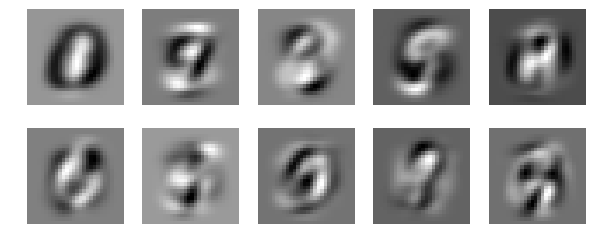

In [4]:
nrows = 2
ncols = 5
subset = pcs[:10]
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
   plt.subplot(nrows, ncols, i+1)
   plt.imshow(subset[i].reshape((28,28)), cmap='gray')
   plt.axis('off')
plt.axis('off')
plt.show()

#### (b) Plot variance
Plot the variance of all of the principal components—this corresponds to the
singular values. This should be monotonically decreasing.

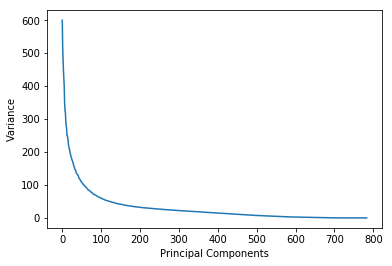

In [5]:
plt.plot(range(len(s)), s, '-')
plt.ylabel('Variance')
plt.xlabel('Principal Components')
plt.show()

#### (c) Dimension reduction


Take a data point in the test data set and project it onto the first m principal components (remember to first subtract the mean). Then, transform that m-length vector back into a 784-length vector and display it as an image (add back the mean). Repeat this for several different values of m. Also, try it on different data points. Describe the results qualitatively. Does it give an accurate representation of the images? How do the results depend on m? Can you describe what the top principal components are capturing?


$V_i = X_i U_c\Sigma_c^{-1}$

$E(X_i) = V_i \Sigma_c U_c^T$

In [6]:
def project_unproject_onto_pcs(c, d):
    Uc = U[:,:c]
    Sc = S[:c,:c]
    d_proj = d.T.dot(Uc).dot(np.linalg.inv(Sc))
    return d_proj.dot(Sc).dot(Uc.T)
dpc = []
pcs = [5,10,25,50,100, 500]
d = data[999]
for i in pcs:
    dpc.append(project_unproject_onto_pcs(i, data[999]))

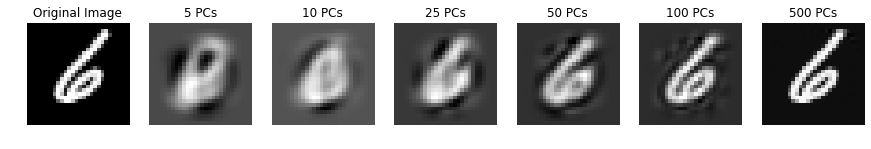

In [7]:
plt.figure(figsize=(15, 105))
plt.subplot(1, 7, 1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(d.reshape((28,28)), cmap='gray')
for i in range(len(dpc)):
    plt.subplot(1,7,i+2)
    plt.imshow(dpc[i].reshape((28,28)), cmap='gray')
    plt.title("" + str(pcs[i]) + " PCs")
    plt.axis('off')
plt.show()

The results do appear to give a fairly accurate representation of the image. As expected, the less components used, the worse the representation of the image is. Also, the more components added, the lower the increase in quality is. This is because the first components account for the highest amount of variance and thus they have the most drastic increase on the quality. The last components account for a very small amount of variance and thus the increase in quality is small.

## Part 2: k-means

Now use k-means to perform unsupervised clustering of the digit data, and try to assess how well the clusters capture the structure of the data. Do not produce more than 50 clusters. Show the centers of the clusters. To evaluate how closely the clusters capture the structure of the data, associate each cluster with the majority label.<br>
Construct plots showing samples of the digits from each cluster, and comment on how well the clusters respect the true digit labels.

In [8]:
data2 = data
c=20
model = KMeans(n_clusters=c, n_jobs=-1)
model.fit(data2)
labels2 = model.predict(data2)
centers = np.array([sum(data2[labels2==i])/data2[labels2==i].shape[0] for i in range(c)])

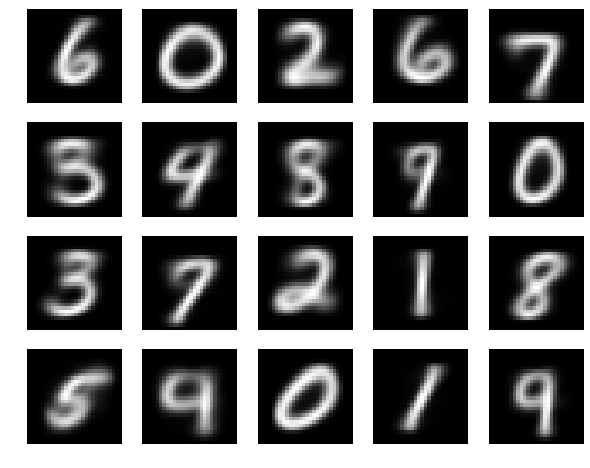

In [9]:
nrows = 4
ncols = 5 
subset = centers
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
   plt.subplot(nrows, ncols, i+1)
   plt.imshow(subset[i].reshape((28,28)), cmap='gray')
   plt.axis('off')
plt.axis('off')
plt.show()

Above I have displayed the image dipicting the center of all of the clusters.

The clusters represent the digits fairly well. It is easy to tell what digit each image depicts. There is definitely a lot of noise in the images, but this is expected in PCA as we do not reduce the noise of the images. I chose to use 20 clusters as when I did 10, not all of the digits showed up. With 20, I was able to get at least 1 cluster for each digit. This is likely because there is a lot of noise and thus digits that aren't the same appear to be somewhat similar. Also, some digits have components that are a part of multiple other digits and thus these digits tend to appear more often. For example, 4,7 and 9 somewhat blend together. Overall, I think these results are good given the limitations of PCA.

## Part 3: Spectral clustering
Compute the bottom few eigenvectors of L except the lowest one. Read off the rows $v_{i,1},v_{i,2},..v_{i,r}$ as the embedding of the digits. Run k-means. Typical choices of the reduced dimension are r=2 or r=3. Compare the result with standard k-means, and describe your findings.


In [11]:
#This was taking a long time, so I only ran it on 1000 data points. It was announced on Canvas that this was okay.
d = 1000
data3 = data[:d]
h = 24
W = np.array([[np.exp(-np.linalg.norm(i - j)**2/h) for j in data3] for i in data3])
D = np.diag([sum(w) for w in W])
Dnh = np.linalg.matrix_power(np.sqrt(D), -1)
I = np.identity(d)
Wtilde = Dnh.dot(W.dot(Dnh))

L = I - Wtilde

In [12]:
r=3
evs, evecs = np.linalg.eig(Wtilde)
order = evs.argsort()[::-1]   
evs_sorted = evs[order]
evecs_sorted = evecs[:,order]
rvs = np.flip(evecs_sorted)[:,1:r+1]

In [14]:
c=20
model3 = KMeans(n_clusters=c, n_jobs=-1)
model3.fit(rvs)
labels3 = model3.predict(rvs)
centers3 = np.array([sum(data3[labels3==i])/data3[labels3==i].shape[0] for i in range(c)])

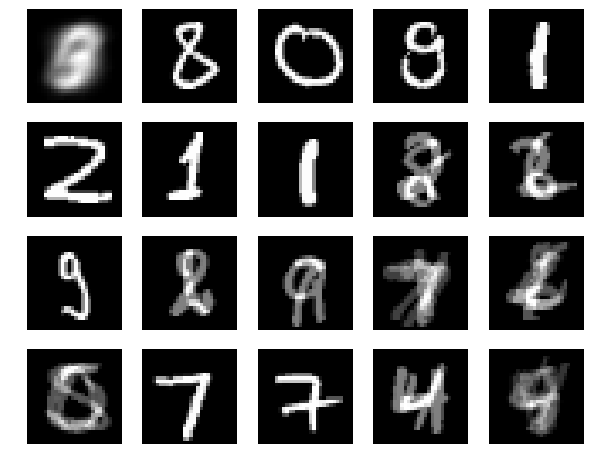

In [15]:
nrows = 4
ncols = 5
subset = centers3
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
   plt.subplot(nrows, ncols, i+1)
   plt.imshow(subset[i].reshape((28,28)), cmap='gray')
   plt.axis('off')
plt.axis('off')
plt.show()

Above I have displayed the image dipicting the center of all of the clusters.

The spectral clusters are much more clear than the normal kmeans. The kmeans is more blurry than the spectral. This  makes sense because by reducing the dimensions, we seek remove similarities in the noise, so that we can isolate the variation that is due to the actual different in the digits. There is some unclarity in these images. Unlike kmeans, there are some clusters that don't have a center that represents a singular number, but I think the results are quite amazing given that we are only using 3 dimensions. Also, this was running slowly, so I only ran it on a very small subset of the data, which could also account for the worse results.

## Part 4: Classification

#### (a) Using the noramlized data from part 2, train the model on the training set, evaluate the model on development set, and calculate the error rate. 

In [16]:
lg=LogisticRegression(fit_intercept=True, C=100000, penalty='l2',
                multi_class='multinomial',solver='lbfgs', max_iter=5000)

In [17]:
# 70,000 was taking too long to run, so I did this with 10,000
data4 = data[:10000]
labels4 = labels[:10000]
Mu = [np.mean(d) for d in data4.T]
data4_c = np.array([d-Mu[i] for (i,d) in enumerate(data4.T)]).T

def getDataRange(data, l,r):
    return data[int(l*len(data)):int(r*len(data))]

training_data = getDataRange(data4_c,0,0.6)
training_labels = getDataRange(labels4,0,0.6)
development_data = getDataRange(data4_c,0.6,0.8)
development_labels = getDataRange(labels4,0.6,0.8)
td_data = getDataRange(data4_c,0,0.8)
td_labels = getDataRange(labels4,0,0.8)
testing_data = getDataRange(data4_c,0.8,1)
testing_labels = getDataRange(labels4,0.8,1)

In [18]:
lg.fit(training_data, training_labels)
predicted_development_labels = lg.predict(development_data)

In [19]:
error = np.mean(development_labels != predicted_development_labels)
print("The error rate is:", error)

The error rate is: 0.126


#### (b) Train multinomial logistic regression model on training data, using the top k principal components. Predict the labels of the development data and compute the error rate. Plot the error as a function of k. How does the error change as the number k vary?

In [20]:
def project_onto_pcs(c, d):
    Uc = U[:,:c]
    Sc = S[:c,:c]
    return d.T.dot(Uc).dot(np.linalg.inv(Sc))

errors = []
# Note, this takes a while to run.
K = [2,3,4,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,100,150,200,300,500,784]
training_data_k = getDataRange(data4_c,0,0.6)
training_labels_k = getDataRange(labels4,0,0.6)
development_data_k = getDataRange(data4_c,0.6,0.8)
development_labels_k = getDataRange(labels4,0.6,0.8)
for k in K:
    proj_training_data = np.array([project_onto_pcs(k, d) for d in training_data_k])
    proj_development_data = np.array([project_onto_pcs(k, d) for d in development_data_k])
    lg.fit(proj_training_data, training_labels_k)
    predicted_proj_development_labels = lg.predict(proj_development_data)
    errors.append(np.mean(development_labels_k != predicted_proj_development_labels))


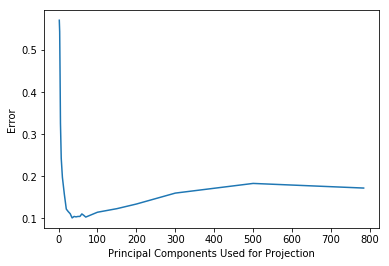

The error is minimized for k = 35
The min k is 35


In [21]:
plt.plot(K, errors, '-')
plt.ylabel('Error')
plt.xlabel('Principal Components Used for Projection')
plt.show()
print("The error is minimized for k =",min([(K[i], e) for (i, e) in enumerate(errors)], key=lambda x:x[1])[0])
print("The min k is",min([(K[i], e) for (i, e) in enumerate(errors)], key=lambda x:x[1])[0])

The error initially decrease drastically at a decreasing rate until it reaches a minimum. Then it error inceases slightly at a decreasing rate and eventually levels. It initially decreases because the first principle components explain a large amount of the variance in the data and thus they create a more accurate representation of the data. The rate at which it decreases decreases as the later eigenvectors explain less of the variance as they have smaller eigenvalues and thus they increase the quality of the data by not as much.<br>

The error eventually starts to increase as the later components represent the noise in the images, which is not necessarily represntitive of what number the image is. For instance, an image of the number 1 and 5 can have similar noise, but they are different numbers. Thus, by including more principle components, these images seem closer together. Thus, the error increases as we include the components with more variance.

#### (c) Pick k that minimizes the error on the development data. Retrain the model using both training and development data. Compute the error rate on testing data. Compare the result to multinomial logistic regression using raw features, and describe your findings.

In [22]:
kmin = min([(K[i], e) for (i, e) in enumerate(errors)], key=lambda x:x[1])[0]
proj_td_data = np.array([project_onto_pcs(kmin, d) for d in td_data])
proj_testing_data = np.array([project_onto_pcs(kmin, d) for d in testing_data])

lg.fit(proj_td_data, td_labels)
predicted_proj_testing_labels = lg.predict(proj_testing_data)

lg.fit(td_data, td_labels)
predicted_testing_labels = lg.predict(testing_data)

In [23]:
error_proj = np.mean(testing_labels != predicted_proj_testing_labels)
error_raw = np.mean(testing_labels != predicted_testing_labels)
print("The error rate is:", error_proj)
print("The error rate with raw features is:", error_raw)

The error rate is: 0.1135
The error rate with raw features is: 0.133


As you can see, the error rate when using only kmin components gets about 2% of the labels correct more than the raw one. This is extremely interesting to me and kind of unexpected because not only is using less dimensions faster and less computationally expensive, but also produces better data. However, it does make sense given that by projecting onto the first kmin components, we reduce the noise in the images, which should produce better results. I really enjoyed this exercise and found the insights extremely interesting.